<a href="https://colab.research.google.com/github/AashiDutt/AI-and-ML-for-Coders/blob/main/Chapter_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab contains code for:

1. Using convolutions for sequence data

2. Working with NASA Weather data (GISS surface temperature analysis)

3. Working with KNMI Climate Explorer dataset

4. Replacing SimpleRNNs with GRU's

5. Replacing GRUs with LSTM

In [2]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [3]:
# Imports

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


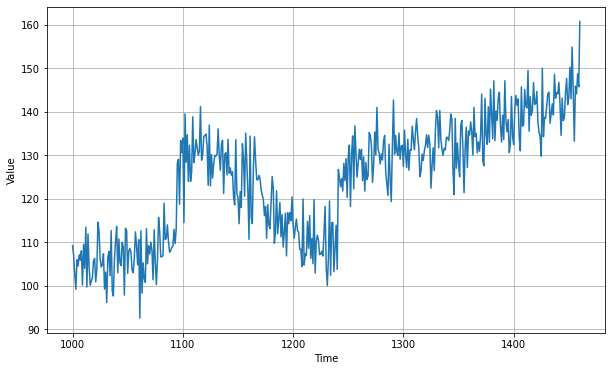

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [6]:
# Creating windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', activation='relu', input_shape=[None, 1]))
  
  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(momentum=0.5, lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 24 Complete [00h 01m 25s]
loss: 61.81985092163086

Best loss So Far: 59.91740290323893
Total elapsed time: 00h 39m 06s
INFO:tensorflow:Oracle triggered exit


Applying optimum results found from previous code

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, 
                            shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=9,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, input_shape=[window_size], 
                           activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)



Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 5ms/step - loss: 585.9074
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 108.8365
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 85.5486
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 77.7024
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 71.8139
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 68.9212
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 69.1413
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 66.1266
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 67.5498
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 64.9251
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 65.9184
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 67.0972
Epoch 13/100
31/31 [===============

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

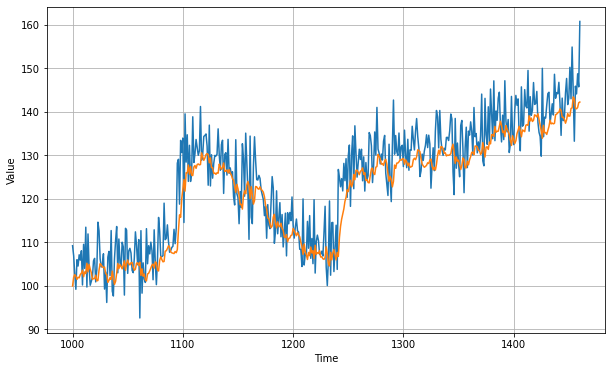

In [18]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0516014

Working with NASA Weather data (GISS surface temperature analysis)

In [1]:
#imports

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Data

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv \
    -O /tmp/station.csv

--2022-02-26 04:18:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘/tmp/station.csv’

/tmp/station.csv    100%[===================>]   6.82K  --.-KB/s    in 0s      

2022-02-26 04:18:22 (53.6 MB/s) - ‘/tmp/station.csv’ saved [6979/6979]



In [6]:
#Read data

def get_data():
  data_file = "/tmp/station.csv"
  f = open(data_file)
  data = f.read()
  f.close()

  lines = data.split('\n')
  header = lines[0].split(',') #0th has header
  lines = lines[1:] #rest has lines
  temperatures = []
  for line in lines:
    if line:
      linedata = line.split(',')
      linedata = linedata[1:13] 
      for item in linedata:
        if item:
          temperatures.append(float(item))
  
  series = np.asarray(temperatures)
  time = np.arange(len(temperatures), dtype = "float32") #returns evenly spaced values
  return time, series


In [7]:
#normalized time series

time, series = get_data()
mean = series.mean(axis = 0)
series -=mean
std = series.std(axis = 0)
series /= std 

In [8]:
#split data --- total data = 840  

split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

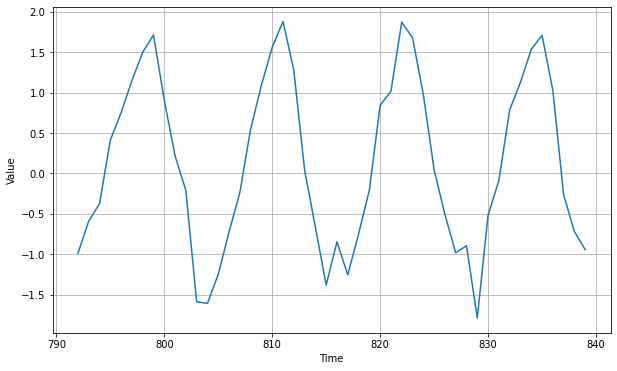

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [12]:
# data is a numpy array, use windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [13]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size,batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size,batch_size, shuffle_buffer_size)

In [14]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.SimpleRNN(100, return_sequences = True),
                                    tf.keras.layers.SimpleRNN(100),
                                    tf.keras.layers.Dense(1)
])

In [29]:
optimizer = tf.keras.optimizers.SGD(lr = 1.5e-6, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),optimizer = optimizer, metrics = ['mae'])

history = model.fit(dataset, epochs = 100, verbose = 1, validation_data = valid_dataset)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


64/64 [==============================] - 3s 18ms/step - loss: 0.0338 - mae: 0.2081 - val_loss: 0.0422 - val_mae: 0.2263
Epoch 2/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0338 - mae: 0.2081 - val_loss: 0.0422 - val_mae: 0.2263
Epoch 3/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0338 - mae: 0.2081 - val_loss: 0.0422 - val_mae: 0.2262
Epoch 4/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0338 - mae: 0.2081 - val_loss: 0.0422 - val_mae: 0.2262
Epoch 5/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0338 - mae: 0.2081 - val_loss: 0.0422 - val_mae: 0.2263
Epoch 6/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0338 - mae: 0.2080 - val_loss: 0.0422 - val_mae: 0.2263
Epoch 7/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0338 - mae: 0.2080 - val_loss: 0.0422 - val_mae: 0.2262
Epoch 8/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0338 - mae: 

In [37]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [38]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

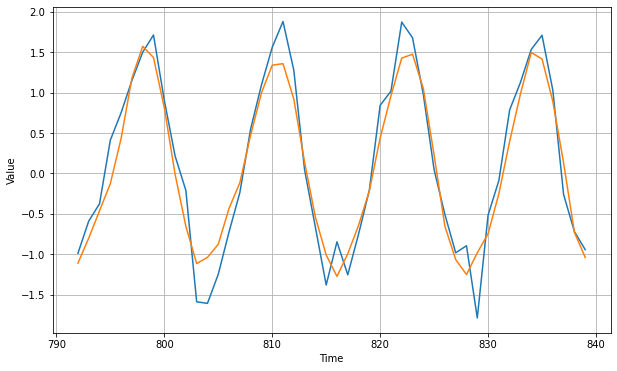

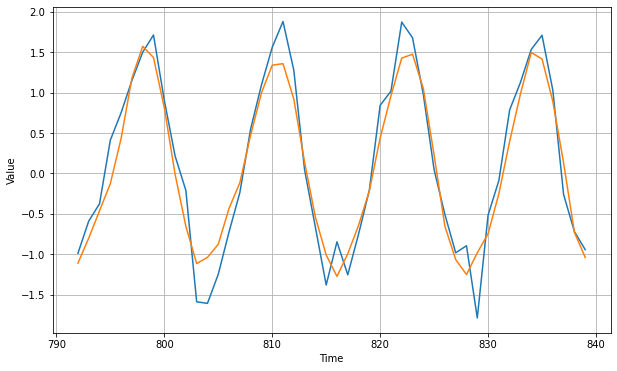

In [39]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [40]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.24099576


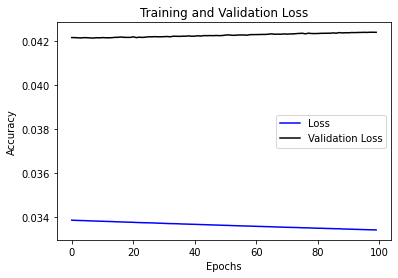

<Figure size 432x288 with 0 Axes>

In [41]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

KNMI Climate Explorer dataset

In [2]:
#dataset

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/tdaily_cet.dat.txt \
    -O /tmp/tdaily_cet.dat.txt

--2022-02-26 06:06:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/tdaily_cet.dat.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1728976 (1.6M) [text/plain]
Saving to: ‘/tmp/tdaily_cet.dat.txt’

/tmp/tdaily_cet.dat 100%[===================>]   1.65M  --.-KB/s    in 0.01s   

2022-02-26 06:06:23 (120 MB/s) - ‘/tmp/tdaily_cet.dat.txt’ saved [1728976/1728976]



In [8]:
def get_data():
  data_file = "/tmp/tdaily_cet.dat.txt"
  f = open(data_file)
  data = f.read()
  f.close()

  lines = data.split('\n')
  temperatures = []
  for line in lines:
    if line:
      linedata = line.split(' ')
      temperatures.append(float(linedata[1]))
  
  series = np.asarray(temperatures)
  time = np.arange(len(temperatures), dtype = "float32")

  return time, series


In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [10]:
time, series = get_data()
mean = series.mean(axis = 0)
series -=mean
std = series.std(axis = 0)
series /= std

In [11]:
split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

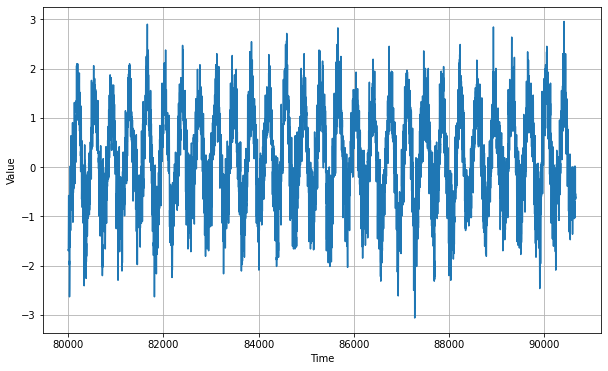

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [15]:
# total datapoints = 90663 ---- train = 80,000 ---- validation = 10663

window_size = 60
batch_size = 120
shuffle_buffer_size = 240

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.SimpleRNN(100), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=10,  verbose=1, validation_data=valid_dataset)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


667/667 [==============================] - 59s 87ms/step - loss: 0.1599 - mae: 0.4456 - val_loss: 0.1000 - val_mae: 0.3548
Epoch 2/10
667/667 [==============================] - 56s 84ms/step - loss: 0.0963 - mae: 0.3471 - val_loss: 0.0823 - val_mae: 0.3214
Epoch 3/10
667/667 [==============================] - 56s 84ms/step - loss: 0.0839 - mae: 0.3233 - val_loss: 0.0734 - val_mae: 0.3037
Epoch 4/10
667/667 [==============================] - 56s 84ms/step - loss: 0.0769 - mae: 0.3091 - val_loss: 0.0679 - val_mae: 0.2921
Epoch 5/10
667/667 [==============================] - 56s 84ms/step - loss: 0.0723 - mae: 0.2994 - val_loss: 0.0641 - val_mae: 0.2837
Epoch 6/10
667/667 [==============================] - 56s 84ms/step - loss: 0.0690 - mae: 0.2922 - val_loss: 0.0612 - val_mae: 0.2774
Epoch 7/10
667/667 [==============================] - 56s 84ms/step - loss: 0.0665 - mae: 0.2867 - val_loss: 0.0590 - val_mae: 0.2724
Epoch 8/10
667/667 [==============================] - 56s 84ms/step - los

In [17]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

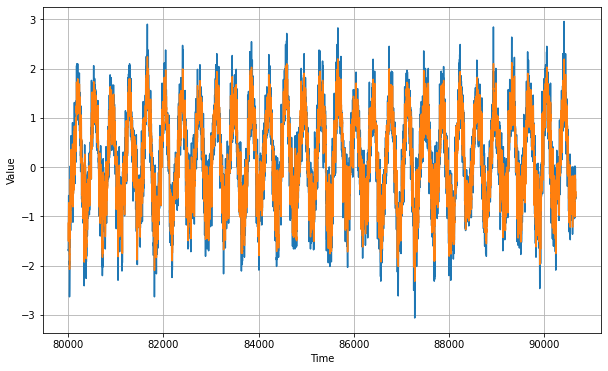

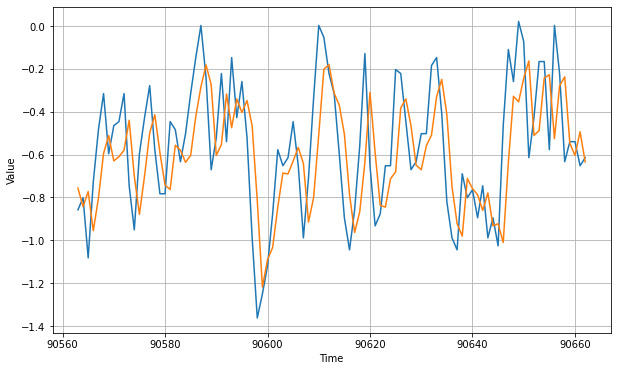

In [19]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [20]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.26221353


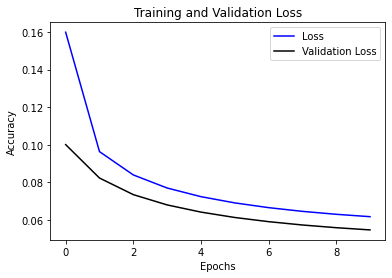

<Figure size 432x288 with 0 Axes>

In [21]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

Replacing SimpleRNNs with GRU's 

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True,dropout = 0.1, recurrent_dropout = 0.1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100,dropout = 0.1, recurrent_dropout = 0.1)), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=10,  verbose=1, validation_data=valid_dataset)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


667/667 [==============================] - 591s 871ms/step - loss: 0.3750 - mae: 0.7523 - val_loss: 0.2759 - val_mae: 0.6258
Epoch 2/10
667/667 [==============================] - 576s 864ms/step - loss: 0.2403 - mae: 0.5770 - val_loss: 0.1780 - val_mae: 0.4861
Epoch 3/10
667/667 [==============================] - 576s 863ms/step - loss: 0.1644 - mae: 0.4647 - val_loss: 0.1262 - val_mae: 0.4016
Epoch 4/10
667/667 [==============================] - 574s 861ms/step - loss: 0.1258 - mae: 0.4012 - val_loss: 0.1013 - val_mae: 0.3572
Epoch 5/10
667/667 [==============================] - 575s 862ms/step - loss: 0.1072 - mae: 0.3683 - val_loss: 0.0892 - val_mae: 0.3345
Epoch 6/10
667/667 [==============================] - 575s 862ms/step - loss: 0.0982 - mae: 0.3514 - val_loss: 0.0829 - val_mae: 0.3223
Epoch 7/10
667/667 [==============================] - 576s 863ms/step - loss: 0.0934 - mae: 0.3421 - val_loss: 0.0795 - val_mae: 0.3156
Epoch 8/10
667/667 [==============================] - 574s 

In [ ]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

In [ ]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

Replacing GRUs with LSTMs

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.LSTM(100), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=10,  verbose=1, validation_data=valid_dataset)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


667/667 [==============================] - 192s 283ms/step - loss: 0.3428 - mae: 0.7114 - val_loss: 0.2321 - val_mae: 0.5650
Epoch 2/10
667/667 [==============================] - 188s 281ms/step - loss: 0.1884 - mae: 0.4991 - val_loss: 0.1396 - val_mae: 0.4212
Epoch 3/10
667/667 [==============================] - 188s 281ms/step - loss: 0.1382 - mae: 0.4204 - val_loss: 0.1231 - val_mae: 0.3928
Epoch 4/10
667/667 [==============================] - 188s 281ms/step - loss: 0.1309 - mae: 0.4083 - val_loss: 0.1210 - val_mae: 0.3895
Epoch 5/10
667/667 [==============================] - 186s 279ms/step - loss: 0.1295 - mae: 0.4060 - val_loss: 0.1201 - val_mae: 0.3881
Epoch 6/10
667/667 [==============================] - 185s 278ms/step - loss: 0.1287 - mae: 0.4045 - val_loss: 0.1194 - val_mae: 0.3868
Epoch 7/10
667/667 [==============================] - 185s 277ms/step - loss: 0.1279 - mae: 0.4031 - val_loss: 0.1186 - val_mae: 0.3856
Epoch 8/10
667/667 [==============================] - 184s 

In [29]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [30]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

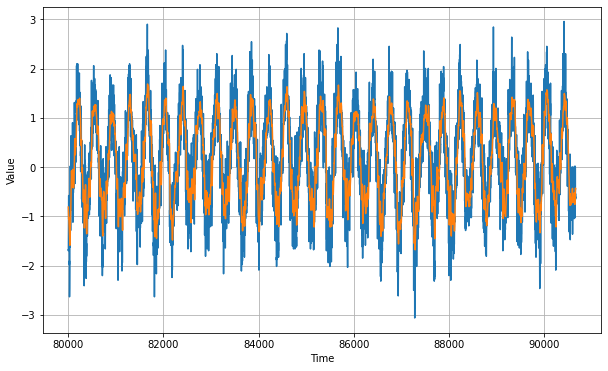

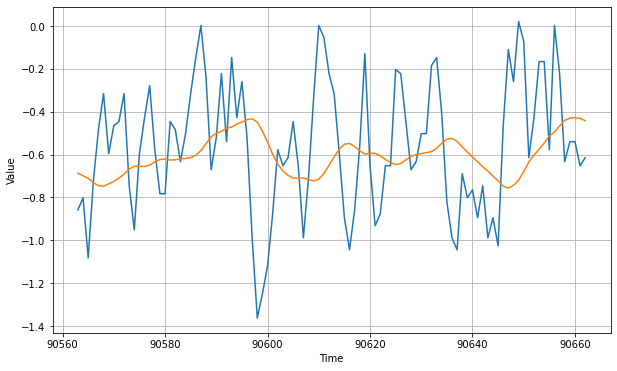

In [31]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [32]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.38321447


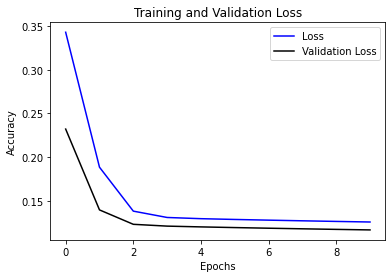

<Figure size 432x288 with 0 Axes>

In [33]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()